<a href="https://colab.research.google.com/github/greek-proverb-atlas/proverbs.gr/blob/main/bert-gr-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

root = 'https://raw.githubusercontent.com/ipavlopoulos/paremia/main'
balanced_corpus = pd.read_csv(f"{root}/data/balanced_corpus.csv", index_col=0)
geolocs = pd.read_csv(f'{root}/data/geolocs.csv')
balanced_corpus.lat = balanced_corpus.area.apply(lambda x: geolocs[x].iloc[0])
balanced_corpus.lon = balanced_corpus.area.apply(lambda x: geolocs[x].iloc[1])

i = 0
seed = 2023+i
train, test = train_test_split(balanced_corpus,
                               test_size=0.05,
                               random_state=seed)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [ ]:
!pip install transformers
from transformers import BertModel, BertTokenizer
model_name = 'nlpaueb/bert-base-greek-uncased-v1'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
import torch
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length = 32):
        self.max_length = max_length
        self.labels = df[["lat", "lon"]].values
        self.texts = df.text.apply(lambda txt: tokenizer(txt,
                                                         padding='max_length',
                                                         max_length = self.max_length,
                                                         truncation=True,
                                                         return_tensors="pt")).values

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1, num_classes=2):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 128, bias=True)
        self.norm = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, num_classes, bias=True)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = pooled_output
        x = self.dropout(x)
        x = self.relu(self.linear1(x))
        x = self.norm(x)
        x = self.linear2(x)
        return x

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

from transformers import AutoTokenizer, BertModel

def validate(model, dataloader, device="cpu", criterion=nn.MSELoss()):
    predictions, gold_labels = [], []
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch_id, (val_input, val_label) in enumerate(dataloader):
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            val_batch_loss = criterion(output, val_label)
            predictions.extend(output.cpu().numpy())
            gold_labels.extend(val_label.cpu())
            val_loss += val_batch_loss.item()
    return predictions, gold_labels, val_loss/val_batch_id

def finetune(model, train_data, val_data,
             learning_rate=2e-5, epochs=100, criterion=nn.MSELoss(),
             batch_size=32, max_length=16, patience=5):

    train_losses = []
    val_losses = []

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, drop_last=False)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model.train()
    lowest_loss = 1000
    best_epoch = 0
    epochs_not_improving = 0

    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            total_loss_val = 0
            for batch_id, (train_input, train_label) in tqdm(enumerate(train_dataloader)):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.float())
                total_loss_train += batch_loss.item()
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            train_losses.append(total_loss_train/(batch_id+1))

            predictions, gold_labels, val_loss = validate(model, val_dataloader, device, criterion)
            val_losses.append(val_loss)
            if val_loss < lowest_loss:
                print(f"New best epoch found: {epoch_num} (val loss: {val_loss:.3f})!")
                lowest_loss = val_loss
                best_epoch = epoch_num
                torch.save(model.state_dict(), "checkpoint.pt")
                epochs_not_improving = 0
            else:
                epochs_not_improving += 1
                if epochs_not_improving >= patience:
                    model.load_state_dict(torch.load("checkpoint.pt"))
                    print('Patience is up, restoring the best model and exiting...')
                    break

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/batch_id: .3f} \
                | Val Loss: {val_loss: .3f} (best epoch: {best_epoch} w/val_loss: {lowest_loss:.3f})')
    model.eval()
    return model, train_losses, val_losses

In [ ]:
criterion = nn.MSELoss()
model = BertClassifier(num_classes=2)
max_length = 32

model, train_losses, val_losses = finetune(model,
                                           Dataset(train, max_length=max_length),
                                           Dataset(dev, max_length=max_length),
                                           epochs=100,
                                           max_length=max_length,
                                           learning_rate=2e-5,
                                           criterion=criterion)

324it [03:07,  1.73it/s]


Epochs: 1 | Train Loss:  1063.757                 | Val Loss:  1121.210 (best epoch: 0 w/val_loss: 1000.000)


324it [02:18,  2.34it/s]


New best epoch found: 1 (val loss: 11.116)!
Epochs: 2 | Train Loss:  22.843                 | Val Loss:  11.116 (best epoch: 1 w/val_loss: 11.116)


324it [02:17,  2.36it/s]


New best epoch found: 2 (val loss: 10.041)!
Epochs: 3 | Train Loss:  9.201                 | Val Loss:  10.041 (best epoch: 2 w/val_loss: 10.041)


324it [02:17,  2.36it/s]


Epochs: 4 | Train Loss:  6.761                 | Val Loss:  10.535 (best epoch: 2 w/val_loss: 10.041)


324it [02:17,  2.35it/s]


Epochs: 5 | Train Loss:  4.381                 | Val Loss:  10.869 (best epoch: 2 w/val_loss: 10.041)


324it [02:20,  2.30it/s]


Epochs: 6 | Train Loss:  2.486                 | Val Loss:  11.311 (best epoch: 2 w/val_loss: 10.041)


324it [02:23,  2.25it/s]


Epochs: 7 | Train Loss:  1.440                 | Val Loss:  11.234 (best epoch: 2 w/val_loss: 10.041)


324it [02:22,  2.28it/s]


Patience is up, restoring the best model and exiting...


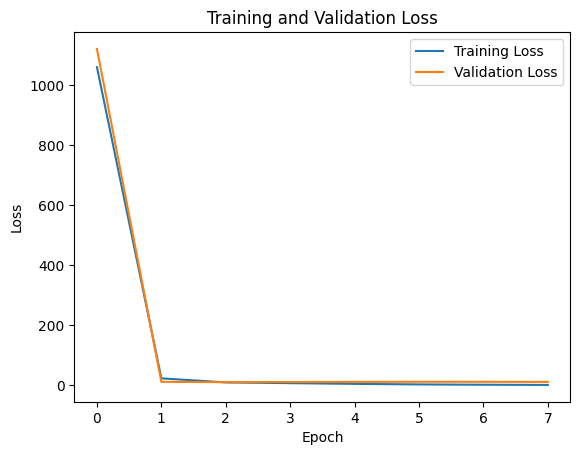

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
_ = plt.legend()

In [ ]:
test_dataloader = torch.utils.data.DataLoader(Dataset(test, max_length=max_length), batch_size=32, drop_last=False)
p,l,_ = validate(model.to("cpu"), test_dataloader, "cpu", criterion)
preds_pd = pd.DataFrame({"pred_lat": np.array(p)[:, 0], "pred_lon": np.array(p)[:, 1],
                         "gold_lat": np.array([i.numpy() for i in l])[:, 0],
                         "gold_lon": np.array([i.numpy() for i in l])[:, 1]})
preds_pd.to_csv("proverb.predictions.csv", index=False)

In [ ]:
print('MAE')
print(f"lat: {mean_absolute_error(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {mean_absolute_error(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")
print('MSE')
print(f"lat: {mean_squared_error(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {mean_squared_error(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")
print('R2')
print(f"lat: {r2_score(preds_pd.pred_lat, preds_pd.gold_lat):.2f}")
print(f"lon: {r2_score(preds_pd.pred_lon, preds_pd.gold_lon):.2f}")

MAE
lat: 1.40
lon: 2.50
MSE
lat: 3.00
lon: 11.43
R2
lat: -6.29
lon: -1.14
